## Neural Signatures of Timing

In [10]:
import os
import sys

import nengo
from nengo.utils.ensemble import response_curves, tuning_curves
import nengo_spa as spa
import nengolib
import nengo_extras
import pytry

import numpy as np
import pandas as pd
import itertools
import string
import scipy
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import uniform_filter1d

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from nengo_extras.plot_spikes import (
    cluster, merge, plot_spikes, preprocess_spikes, sample_by_variance)

%pylab inline
import pylab

%run ../dashedlines.py
%run ../UTC_prospective.py

Populating the interactive namespace from numpy and matplotlib


/Users/Joost/opt/anaconda3/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['pylab']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


### Motor Timing: Wang et al. (2018)

In [2]:
# set parameters
n_trials = 50
target_intervals = np.array([0.8, 1.5])
trial = 0
N = 200
dim = 3

# How to get data? simulate, load_raw, or load agg_data
get_dat_method = 'load_raw'

In [3]:
%%capture

if get_dat_method == 'simulate':
    for i in range(0, n_trials):
        for target_interval in target_intervals:
            UTC_prospective().run(task_type = 'prospective_motor', 
                            n_type = nengo.LIF(),
                            dimensions=dim,
                            N = N, 
                            verbose=True,
                            seed=trial,
                            prestim = 0.5,
                            effective_theta=target_interval,
                            full_output=True,
                            between_gain_noise_std=0.1,
                            within_gain_noise_std=0, 
                            input_noise_std=0,
                            data_dir = 'wang_2018_LIF')
            trial += 1

In [5]:
# note: takes about 30 minutes to load the data
wang_data = pytry.read('wang_2018_LIF')
wang_dt = pd.DataFrame(wang_data)

#### Wang et al. Behavioral Analysis

In [6]:
wang_dt.groupby('effective_theta')['rt'].agg([np.mean, np.std])

,mean,std
effective_theta,,
0.8,839.50,63.510966
1.5,1466.98,163.931356


#### Wang et al. Neural Analysis

In [7]:
# binning response times (see Wang et al. (2018) 'Data Analysis')
short_bins = np.linspace(730, 870, 8)
long_bins = np.linspace(1280, 1640, 10)
bins = np.concatenate([short_bins, long_bins])
wang_dt['bin'] = np.where(wang_dt['effective_theta']==target_intervals[0], 
                         np.digitize(wang_dt['rt'], short_bins),
                         np.digitize(wang_dt['rt'], long_bins))

In [8]:
# Create spike matrices - time x neuron x trial - binned in different response times
# for short intervals
conditions = (wang_dt['effective_theta'] == target_intervals[0])
wang_short = [None] * (len(short_bins)+1)
for b in np.sort(wang_dt[conditions]['bin'].unique()):
    temp = []
    conditions = (wang_dt['effective_theta'] == target_intervals[0]) & (wang_dt['bin'] == b)
    for trial in range(0, len(wang_dt[conditions])):
        temp.append(wang_dt[conditions].iloc[trial].state_spikes)
    
    temp = np.dstack(temp)
    
    wang_short[b] = np.mean(temp, axis=2)
    
# and long intervals
conditions = (wang_dt['effective_theta'] == target_intervals[1])
wang_long = [None] * (len(long_bins)+1)

for b in np.sort(wang_dt[conditions]['bin'].unique()):
    temp = []
    conditions = (wang_dt['effective_theta'] == target_intervals[1]) & (wang_dt['bin'] == b)
    for trial in range(0, len(wang_dt[conditions])):
        temp.append(wang_dt[conditions].iloc[trial].state_spikes)
    
    temp = np.dstack(temp)
    
    wang_long[b] = np.mean(temp, axis=2)

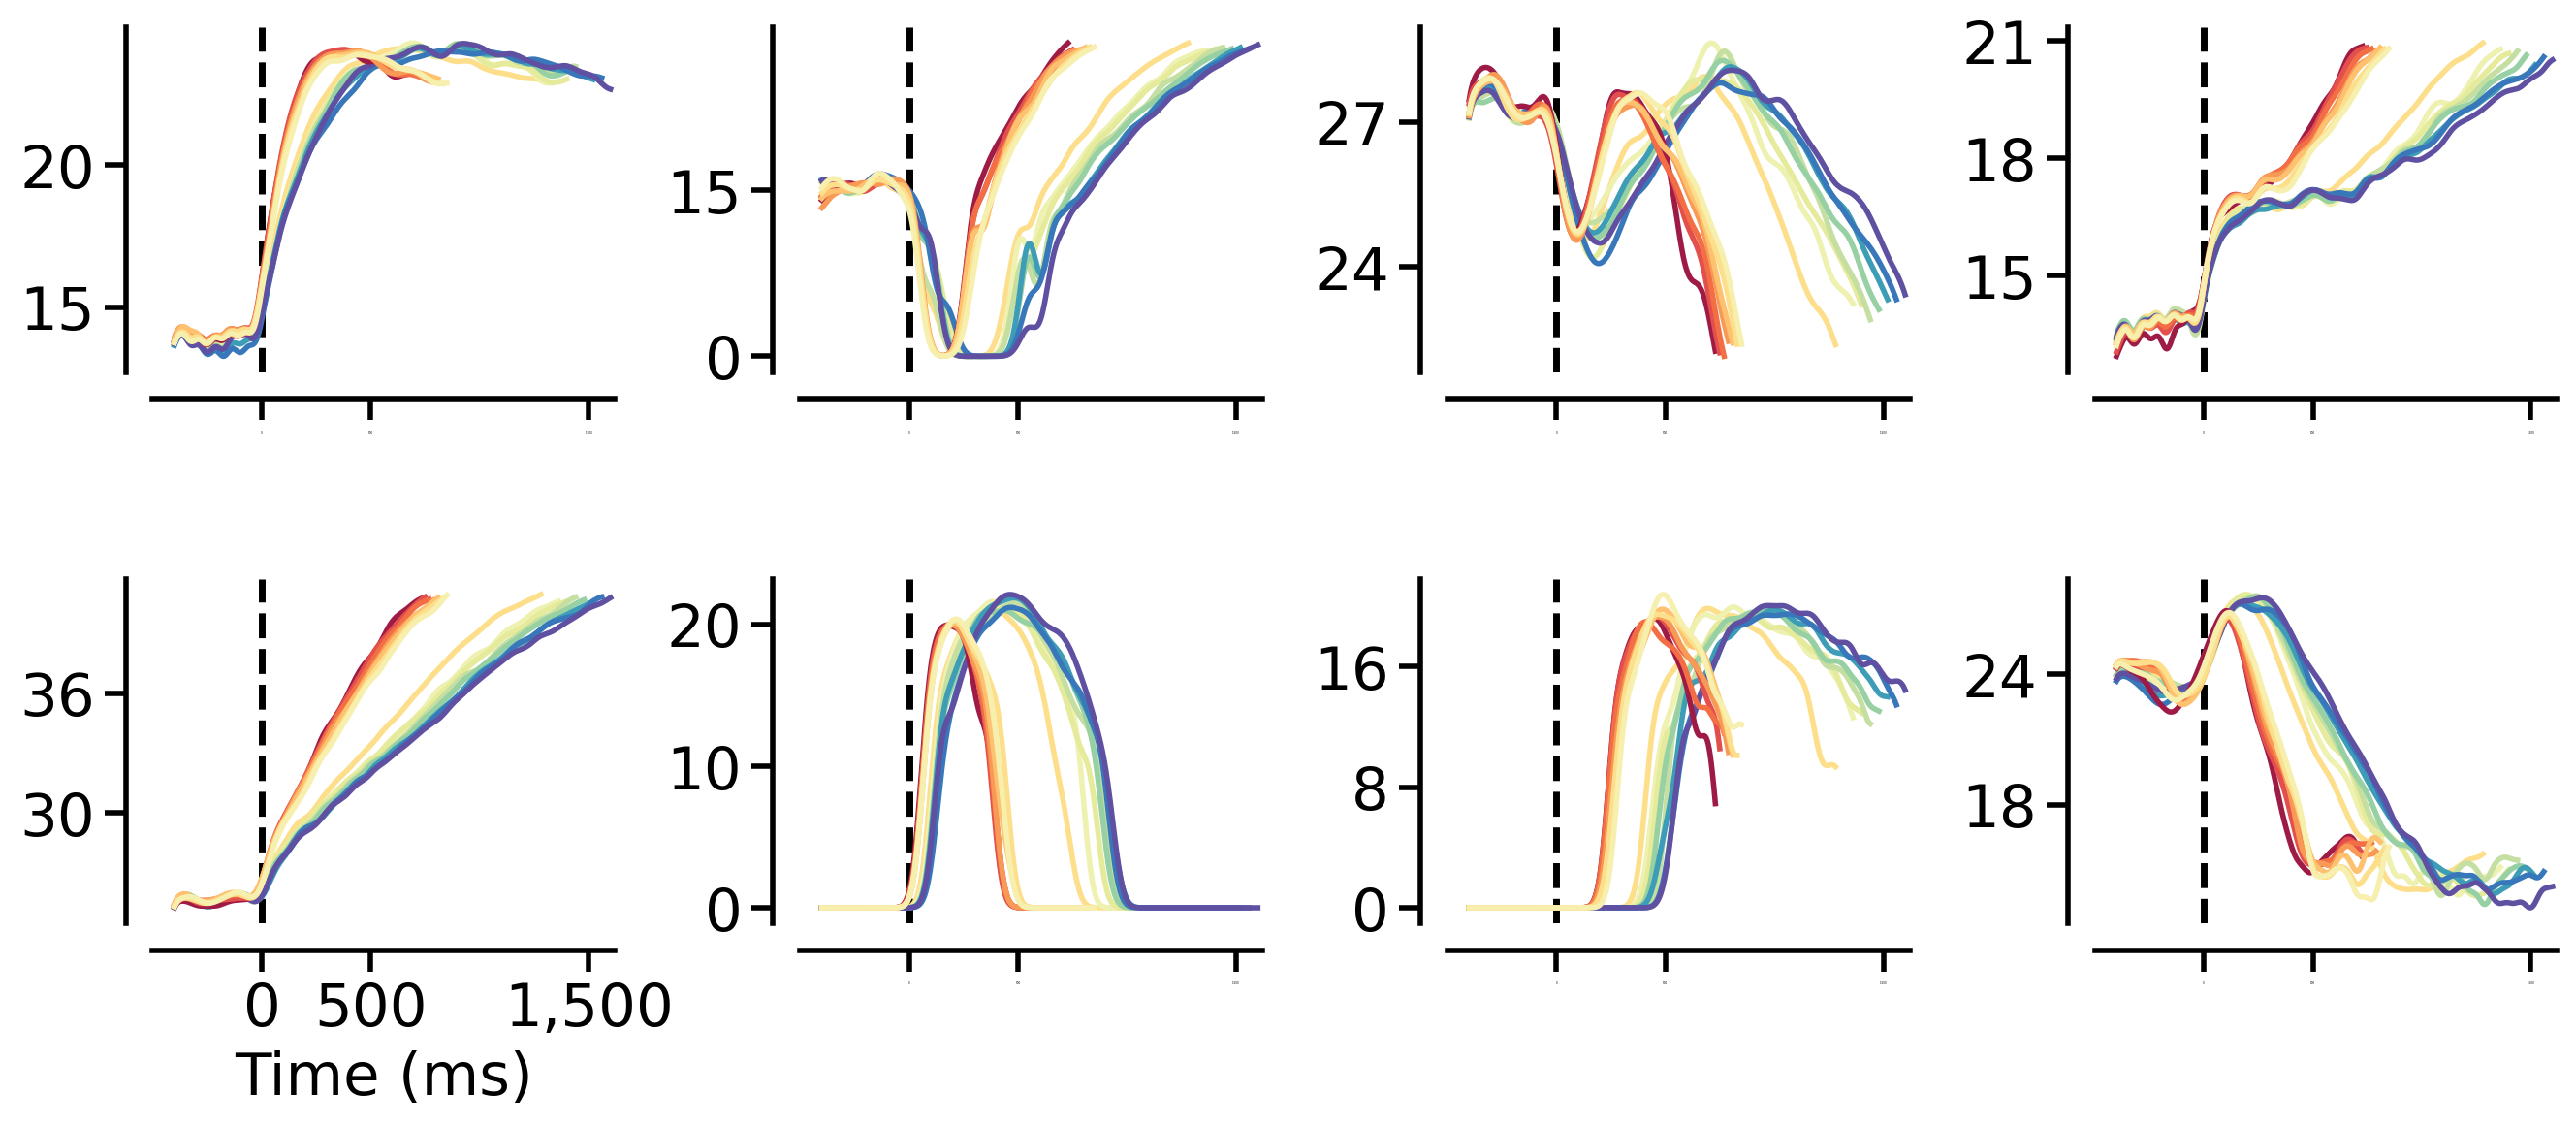

In [11]:
# Use same color maps as Wang et al. (2018)
colors = ['#5F50A2', '#3877BA', '#3D9DB7', '#97D0A3', '#C4DFA1', 
'#E5EB9A', '#EEF1B0', '#F7EFAE', '#FDDF8B', '#FDC16F', 
'#F89956', '#F36E44', '#E24F4C', '#9E1B45'][::-1]
cmap_long = ['#5F50A2', '#3877BA', '#3D9DB7', '#97D0A3', '#C4DFA1', '#E5EB9A', '#EEF1B0'][::-1]
cmap_short = ['#F7EFAE', '#FDDF8B', '#FDC16F', '#F89956', '#F36E44', '#E24F4C', '#9E1B45'][::-1]

#lc_short = LineCollection(len(cmap_short) * [[(0, 0)]], lw=10,
#                    colors=cmap_short)
#lc_long = LineCollection(len(cmap_long) * [[(0, 0)]], lw=10,
#                    colors=cmap_long)

#neurons = [25, 17, 226, 28] # v1
#neurons = [109, 226, 177, 89] # v2
neurons = [152, 177, 17, 384,
           109, 226, 24,  89]

#neurons = [0, 1, 2, 3, 4, 5, 6, 7] # tally
# 152 for the top left in Wang et al.
# 109 or 384 or 447 or 489 for top right
# 321 also a beauty
# 89 or 523 for decaying
#neurons = np.array(neurons) + 8

fig, axes = plt.subplots(2, 4, figsize=(4*4,6), dpi=200, 
                         sharey=False, sharex=True, squeeze=True)

axes = axes.flatten()
for n in range(0,len(neurons)):
    axes[n].yaxis.set_major_locator(MaxNLocator(integer=True))
    axes[n].locator_params(nbins=3)

    axes[n].axvline(x=0, ls='--', color='black', lw=2.5)
    
    conditions = (wang_dt['effective_theta'] == target_intervals[1])
    for b in np.sort(wang_dt[conditions]['bin'].unique())[:-2]:
        time_axis = np.arange(-wang_dt['prestim'].values[0]+0.1, long_bins[b]/1000, 0.001)
        activity = gaussian_filter1d(wang_long[b][:,neurons[n]], 40)[100:len(time_axis)+100]
        axes[n].plot(time_axis,
                     activity,
                     color=colors[b+5],
                     lw=2)


    conditions = (wang_dt['effective_theta'] == target_intervals[0])
    for b in np.sort(wang_dt[conditions]['bin'].unique())[:-2]:
        time_axis = np.arange(-wang_dt['prestim'].values[0]+0.1, short_bins[b]/1000, 0.001)
        activity = gaussian_filter1d(wang_short[b][:,neurons[n]], 40)[100:len(time_axis)+100]
        axes[n].plot(time_axis,
                     activity,
                     color=colors[b],
                     lw=2)
    
    axes[n].yaxis.set_ticks_position('left')
    axes[n].xaxis.set_ticks_position('bottom')
    axes[n].set_xlim(-0.500, 1.62)
    #axes[n].set_ylim(bottom=0)
    axes[n].set_xticks([0, 0.5, 1.5])
    
    axes[n].tick_params('both', length=8, width=2, which='both', labelsize=22)
    
    if n == 4:
        axes[n].set_xticklabels(['0', '500', '1,500'])
        axes[n].set_xlabel('Time (ms)', size=22)
    else:
        axes[n].tick_params(axis='x', labelsize=0)
        
            
    
    #axes[n].tick_params(axis='x', labelsize=30)

    axes[n].spines['right'].set_visible(False)
    axes[n].spines['top'].set_visible(False)
    axes[n].spines['left'].set_position(('outward', 10))
    axes[n].spines['bottom'].set_position(('outward', 10))
    axes[n].spines['left'].set_linewidth(2)
    axes[n].spines['bottom'].set_linewidth(2)
    
fig.subplots_adjust(wspace=0.4, hspace=0.6)
#fig.savefig('wang2018_scaling.png', dpi=500, bbox_inches='tight')
#fig.savefig('wang2018_scaling.pdf', dpi=500, bbox_inches='tight')


### Sensory Timing: Gouvea et al. (2015)

In [12]:
# set parameters
n_trials = 50
gouvea_target_intervals = np.array([0.6, 1.05, 1.26, 1.38, 1.62, 1.74, 1.95, 2.4])
prestim = 0.5
poststim = 0.5
N = 200

# How to get data? simulate, load_raw
get_dat_method = 'load_raw'

In [13]:
%%capture
trial = 0

if get_dat_method == 'simulate':
    for i in range(0, n_trials):
        for target_interval in gouvea_target_intervals:
            UTC_prospective().run(task_type = 'prospective_sensory', 
                            n_type = nengo.LIF(),
                            dimensions=3,
                            N=N, 
                            verbose=True,
                            seed=trial,
                            prestim = prestim,
                            poststim = prestim,
                            #effective_theta=np.mean(gouvea_target_intervals),
                            effective_theta = 2.4,
                            trial_duration=target_interval,
                            full_output=True,
                            between_gain_noise_std=0.1,
                            within_gain_noise_std=0, 
                            input_noise_std=0,
                            data_dir = 'gouvea_2015_LIF')
            trial += 1

In [14]:
gouvea_data = pytry.read('gouvea_2015_LIF')
gouvea_dt = pd.DataFrame(gouvea_data)

In [9]:
gouvea_dt['trial_duration'] = gouvea_dt['trial_duration'] - 0.5
for i in range(len(gouvea_dt)):
    gouvea_dt['estimate'][i] = nengo.Alpha(0.05).filt(
        gouvea_dt['state'].values[i][:-int(poststim*1000),0])[-1]

/Users/Joost/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [414]:
# Create spike matrices - time x neuron x trial - for each target duration

# Determine model response, short=False, long=True
gouvea_dt['response'] = (gouvea_dt['estimate'] > 0.70).astype(bool)

# seperated by 'short' responses
gouvea_short = [None] * len(gouvea_target_intervals)
for i in range(0, len(gouvea_target_intervals)):
    temp = []
    conditions = (gouvea_dt['response'] == False) & (gouvea_dt['trial_duration'] == gouvea_target_intervals[i])
    for trial in range(0, len(gouvea_dt[conditions])):
        temp.append(gouvea_dt[conditions].iloc[trial].state_spikes)
    
    if temp != []:
        temp = np.dstack(temp)
        gouvea_short[i] = np.mean(temp, axis=2)
    else:
        gouvea_short[i] = temp 
    
# and 'long' responses
gouvea_long = [None] * (len(gouvea_target_intervals)+1)
for i in range(0, len(gouvea_target_intervals)):
    temp = []
    conditions = (gouvea_dt['response'] == True) & (gouvea_dt['trial_duration'] == gouvea_target_intervals[i])
    for trial in range(0, len(gouvea_dt[conditions])):
        temp.append(gouvea_dt[conditions].iloc[trial].state_spikes)
    
    if temp != []:
        temp = np.dstack(temp)
        gouvea_long[i] = np.mean(temp, axis=2)
    else:
        gouvea_long[i] = temp 
    

In [12]:
gouvea_dt_behavior = gouvea_dt
gouvea_dt_behavior = gouvea_dt_behavior[['trial_duration', 'estimate']]
gouvea_dt_behavior['response'] = (gouvea_dt_behavior['estimate'] > 0.70).astype(bool)

/Users/Joost/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
gouvea_dt_behavior.groupby('trial_duration')['estimate', 'response'].agg([np.mean, np.std])

estimate           response          
                    mean       std     mean       std
trial_duration                                       
0.60            0.223366  0.063822     0.00  0.000000
1.05            0.471507  0.125390     0.00  0.000000
1.26            0.592597  0.143329     0.24  0.431419
1.38            0.635305  0.152921     0.40  0.494872
1.62            0.712358  0.148690     0.58  0.498569
1.74            0.794692  0.144589     0.78  0.418452
1.95            0.887018  0.135852     0.92  0.274048
2.40            0.898423  0.160402     0.90  0.303046

In [407]:
# Empirical
# (reconstructing the logistic curve)
n_trials = 522
p_long_empirical = np.array([0.05, 0.11, 0.19, 0.26, 0.62, 0.78, 0.89, 0.95])
y_empirical = np.array([])
X_empirical = np.array([])

for i in range(len(p_long_empirical)):
    X_empirical = np.append(X_empirical, np.repeat(gouvea_target_intervals[i], n_trials))
    n1 = int(n_trials * p_long_empirical[i])
    n0 = n_trials - n1
    y_empirical = np.append(y_empirical, 
                  np.concatenate([np.repeat(1, n1),
                                  np.repeat(0, n0)]))

X_empirical = X_empirical.reshape(-1, 1)    
    
clf_empirical = LogisticRegression(random_state=0, C=1e5)
clf_empirical.fit(X_empirical, y_empirical)

/Users/Joost/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [408]:
from sklearn.linear_model import LogisticRegression

y = gouvea_dt_behavior['response'].values.astype(int)
X = gouvea_dt_behavior['trial_duration'].values
X = X.reshape(-1, 1)

clf = LogisticRegression(random_state=0, C=1e5)
clf.fit(X, y)

/Users/Joost/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [409]:
N = gouvea_dt_behavior.groupby('trial_duration')['response'].apply(len).values
p = gouvea_dt_behavior.groupby('trial_duration')['response'].apply(np.mean).values
q = 1-p

p_long_std = np.sqrt(N*p*q)/n_trials

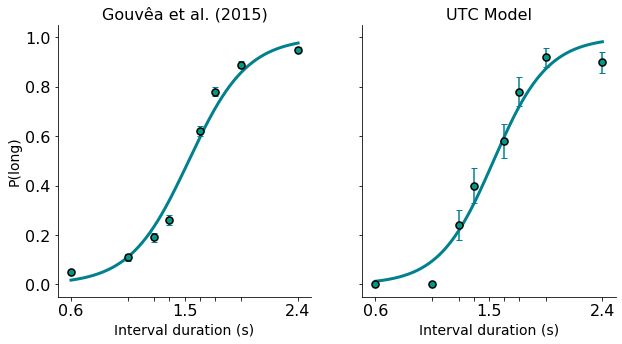

In [410]:
from scipy.special import expit

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
X_test = np.linspace(0.6, 2.4, 300)

# Empirical
ax1.set_title('Gouvêa et al. (2015)')
ax1.set_ylim(-0.05, 1.05)
p_long_empirical = np.array([0.05, 0.11, 0.19, 0.26, 0.62, 0.78, 0.89, 0.95])

N = np.repeat(n_trials, len(p_long_empirical))
p = p_long_empirical
q = 1-p
p_long_empirical_std = np.sqrt(N*p*q)/N

ax1.scatter(gouvea_target_intervals, p_long_empirical,
            color='#009985', edgecolor='black', s=50, lw=1.5, zorder=20)
ax1.errorbar(gouvea_target_intervals, p_long_empirical, p_long_empirical_std, color='#01808e',
             ls='none', capsize=3)
loss = expit(X_test * clf_empirical.coef_ + clf_empirical.intercept_).ravel()
ax1.plot(X_test, loss, color='#01808e', linewidth=3)

ax1.set_xticks(np.sort(np.hstack([gouvea_target_intervals, 1.5])))
ax1.set_xticklabels([0.6, None, None, None, 1.5, None, None, None, 2.4])

ax1.set_ylabel('P(long)')
ax1.set_xlabel('Interval duration (s)')

# Model
ax2.set_title('UTC Model')
ax2.set_ylim(-0.05, 1.05)
p_long = gouvea_dt_behavior.groupby('trial_duration')['response'].agg([np.mean]).values

N = gouvea_dt_behavior.groupby('trial_duration')['response'].apply(len).values
p = gouvea_dt_behavior.groupby('trial_duration')['response'].apply(np.mean).values
q = 1-p
p_long_std = np.sqrt(N*p*q)/N

ax2.scatter(gouvea_target_intervals, p_long,
            color='#009985', edgecolor='black', s=50, lw=1.5, zorder=20)
ax2.errorbar(gouvea_target_intervals, p_long, p_long_std, color='#01808e',
             ls='none', capsize=3)

loss = expit(X_test * clf.coef_ + clf.intercept_).ravel()
ax2.plot(X_test, loss, color='#01808e', linewidth=3)

ax2.set_xticks(np.sort(np.hstack([gouvea_target_intervals, 1.5])))
ax2.set_xticklabels([0.6, None, None, None, 1.5, None, None, None, 2.4])
ax2.set_yticklabels([])
ax2.set_xlabel('Interval duration (s)')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

fig.savefig('gouvea_behavior.png', dpi=600)
fig.savefig('gouvea_behavior.tiff', dpi=1000, bbox_inches='tight')

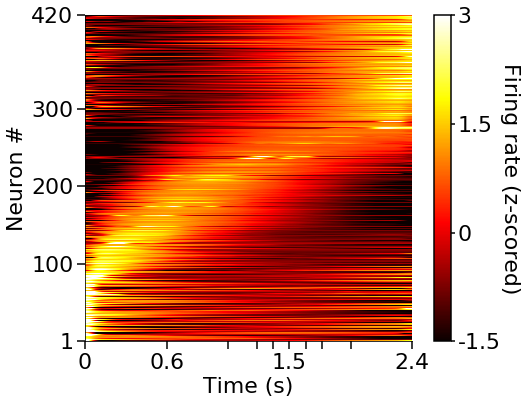

In [57]:
activity = gaussian_filter1d(gouvea_long[7][500:-500,:].T, 50, axis=1)
activity = activity[~np.all(activity == 0, axis=1)]
activity = scipy.stats.zscore(activity, axis=1)
peak_sorting = np.argmax(activity, axis=1).argsort()[::-1]
activity = activity[peak_sorting]

extent = [0, np.shape(activity)[1]/1000, 
          1, np.shape(activity)[0]+1] 

fig, ax = plt.subplots(figsize=(8, 6))
plt.imshow(activity, aspect=extent[1]/extent[3], 
           extent=extent,
           interpolation='nearest', cmap='hot')
cbar = plt.colorbar(ticks=[-1.5, 0, 1.5, 3])
plt.clim(-1.5, 3.)
cbar.set_label('Firing rate (z-scored)', fontsize=22, rotation=270,
              labelpad=20)
cbar.set_ticklabels(['-1.5', '0', '1.5', '3'])
cbar.ax.tick_params(labelsize=22, width=1.5)
cbar.outline.set_linewidth(1.5)

ax.set_xlabel('Time (s)', fontsize=22)
ax.set_ylabel('Neuron #', fontsize=22)
#ax.set_title('All cells\nstimulus 2.4', fontsize=18)
ax.set_yticks([1, 100, 200, 300, 420])
plt.xticks(np.sort(np.hstack([0, gouvea_target_intervals, 1.5])), 
           labels=[0, 0.6, None, None, None, 1.5, None, None, None, 2.4],
           fontsize=22)
plt.yticks(fontsize=22)
ax.tick_params('both', length=8, width=1.5, which='both')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('gouvea_figure2d.png')

In [415]:
baseline = gaussian_filter1d(gouvea_long[7].T, 50, axis=1)[:, 200:400]

activity_2400 = uniform_filter1d(gouvea_long[7].T, size=500, axis=1)[:,]
indices = ~np.all(activity_2400 == 0, axis=1) #& ~np.all(long_activity == 0, axis=1)
activity_2400 = activity_2400[indices]
baseline = baseline[indices]

baseline_mean = np.mean(baseline)
baseline_std = np.std(baseline)

activity_2400 = (activity_2400 - baseline_mean) / baseline_std
peak_sorting = np.argmax(activity_2400, axis=1).argsort()[::-1]
#short_activity = short_activity[:, 200:600]
activity_2400 = activity_2400[peak_sorting]
#short_activity = (short_activity - np.min(short_activity, axis=1)[:, np.newaxis]) / np.ptp(short_activity, axis=1)[:, np.newaxis]
#short_activity = scipy.stats.zscore(short_activity, axis=1)

In [416]:
baseline = gaussian_filter1d(gouvea_long[4][100:400, :], 100, axis=0)
baseline_mean = np.mean(baseline)
baseline_std = np.std(baseline)

short_activity = gaussian_filter1d(gouvea_short[4], 100, axis=0)[:,]
long_activity = gaussian_filter1d(gouvea_long[4], 100, axis=0)[:,]

short_activity = short_activity[:, indices]
long_activity = long_activity[:, indices]

short_activity = (short_activity - baseline_mean) / baseline_std
long_activity = (long_activity - baseline_mean) / baseline_std

#peak_sorting = np.argmax(short_activity, axis=0).argsort()[::-1]

#short_activity = short_activity[peak_sorting]
#long_activity = long_activity[peak_sorting]


### Principal Component Analysis

In [417]:
np.shape(short_activity)

(2620, 441)

In [418]:
# Model PCA
gouvea_pca_transformed = []
gouvea_pca_fit = PCA(n_components=3)
gouvea_pca_fit = gouvea_pca_fit.fit(long_activity[500:-500,:])

gouvea_pca_short = gouvea_pca_fit.transform(short_activity[500:-500,:])
gouvea_pca_long = gouvea_pca_fit.transform(long_activity[500:-500,:])

In [419]:
# Empirical PCA from Gouvea et al.
gouvea_pca_empirical = genfromtxt('gouvea_pca_empirical.txt', delimiter=';')
#gouvea_pca_empirical = np.flip(gouvea_pca_empirical, axis=0)

gouvea_pca_empirical_long = np.array([[22.68, -20.83],
                                      [35.64, -4.90],
                                      [14.90, 16.82],
                                      [-23.21, 7.19],
                                      [-29.02, -9.44],
                                      [-19.52, -25.42]])

gouvea_pca_empirical_short = np.array([[26.51, -19.60],
                                      [36.48, -2.87],
                                      [13.41, 17.25],
                                      [-20.68, 8.84],
                                      [-29.97, -1.40],
                                      [-28.23, -13.59]])

In [420]:
# Checking overall fit of the PCA for the long (i.e. correct response)
# by concatenating PC's

# Model
step = int(gouvea_pca_long.shape[0] / gouvea_pca_empirical.shape[0])
pca1_model = -gouvea_pca_long[0:1620-3*step:step, 0]
pca_min = np.min(pca1_model)
pca_max = np.max(pca1_model)
pca1_model = (pca1_model - pca_min) / (pca_max - pca_min) 

pca2_model = -gouvea_pca_long[0:1620-3*step:step, 1]
pca_min = np.min(pca2_model)
pca_max = np.max(pca2_model)
pca2_model = (pca2_model - pca_min) / (pca_max - pca_min) 

# Empirical
pca1_empirical = gouvea_pca_empirical[:, 0]
pca_min = np.min(pca1_empirical)
pca_max = np.max(pca1_empirical)
pca1_empirical = (pca1_empirical - pca_min) / (pca_max - pca_min)

pca2_empirical = gouvea_pca_empirical[:, 1]
pca_min = np.min(pca2_empirical)
pca_max = np.max(pca2_empirical)
pca2_empirical = (pca2_empirical - pca_min) / (pca_max - pca_min)

gouvea_pca_fit = r2_score(np.concatenate([pca1_empirical, pca2_empirical]),
                          np.concatenate([pca1_model, pca2_model]))
gouvea_pca_fit

0.9200417358700539

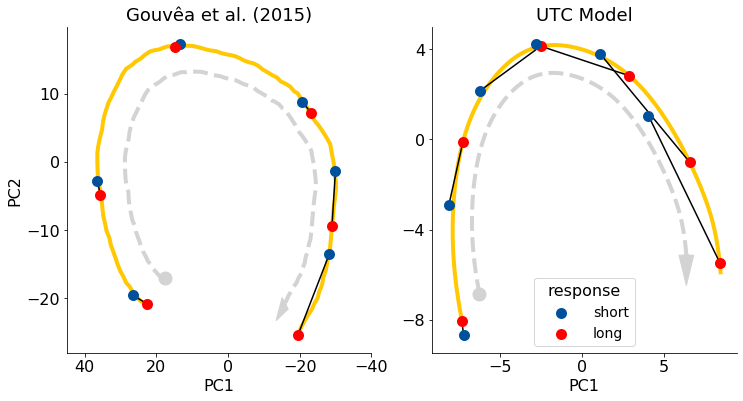

In [421]:
#plt.plot(gouvea_pca_short[:,0],
#         gouvea_pca_short[:,1],
#         lw=3, label='Short judgement', color='blue')
plt.rcParams['font.size'] = '16'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax2.set_title('UTC Model', size=18)
ax2.plot(gouvea_pca_long[:,0],
         -gouvea_pca_long[:,1],
         lw=4, color='#FFC800', zorder=0)

ax2.plot(gouvea_pca_long[:,0] * 0.8 - 0.4,
         -gouvea_pca_long[:,1] * 0.8 - 0.4,
         lw=4, color='lightgrey', ls='--', zorder=0)

ax2.arrow(float(gouvea_pca_long[-1:,0] * 0.8 - 0.4),
         float(-gouvea_pca_long[-1:,1] * 0.8 - 0.4),
         0.0, -0.02, color='lightgrey', width=0.3)

ax2.scatter(float(gouvea_pca_long[0,0] * 0.8 - 0.4),
            float(-gouvea_pca_long[0,1] * 0.8 - 0.4),
            color='lightgrey', lw=8)

pca_scatterpoints_short = gouvea_pca_short[[0, 320, 650, 970, 1300, 1600], :]
pca_scatterpoints_long = gouvea_pca_long[[0, 320, 650, 970, 1300, 1600], :] 

ax2.scatter([], [], label="short", color="#00519D", lw=5)  
ax2.scatter([], [], label="long", color="red", lw=5)

for j in np.arange(0, np.shape(pca_scatterpoints_short)[0]):
    ax2.scatter(x=pca_scatterpoints_short[j,0], y=-pca_scatterpoints_short[j,1],
                color = '#00519D', lw=5, zorder=2)
    ax2.scatter(x=pca_scatterpoints_long[j,0], y=-pca_scatterpoints_long[j,1],
                color = 'red', lw=5, zorder=2)   
    ax2.plot(np.array([pca_scatterpoints_short[-j,0], pca_scatterpoints_long[-j,0]]),
             np.array([-pca_scatterpoints_short[-j,1], -pca_scatterpoints_long[-j,1]]), 
             color='black', zorder=0)
    


ax2.set_xlabel('PC1', size=16)
ax2.set_yticks([4, 0, -4, -8])
#ax2.set_ylabel('PC2', size=16)

ax2.legend(loc='lower center', title='response')

#ax2.spines['right'].set_visible(False)
#ax2.spines['top'].set_visible(False)

# Empirical
ax1.set_title('Gouvêa et al. (2015)', size=18)
ax1.plot(gouvea_pca_empirical[:,0],
         gouvea_pca_empirical[:,1],
         lw=4, color='#FFC800', zorder=0)

ax1.plot(gouvea_pca_empirical[:,0] * 0.8 - 0.4,
         gouvea_pca_empirical[:,1] * 0.8 - 0.4,
         lw=4, color='lightgrey', ls='--', zorder=0)
ax1.arrow((gouvea_pca_empirical[-1:,0] * 0.8 - 0.4)[0],
         (gouvea_pca_empirical[-1:,1] * 0.8 - 0.4)[0],
         0.08, -0.08, color='lightgrey', width=0.8)
ax1.scatter(gouvea_pca_empirical[0,0] * 0.8 - 0.4,
            gouvea_pca_empirical[0,1] * 0.8 - 0.4,
            color='lightgrey', lw=8)

for j in np.arange(0, np.shape(gouvea_pca_empirical_short)[0]):
    ax1.scatter(x=gouvea_pca_empirical_short[j,0], y=gouvea_pca_empirical_short[j,1],
                color = '#00519D', lw=5, zorder=2)
    ax1.scatter(x=gouvea_pca_empirical_long[j,0], y=gouvea_pca_empirical_long[j,1],
                color = 'red', lw=5, zorder=2)   
    ax1.plot(np.array([gouvea_pca_empirical_short[j,0], gouvea_pca_empirical_long[j,0]]),
             np.array([gouvea_pca_empirical_short[j,1], gouvea_pca_empirical_long[j,1]]), 
             color='black', zorder=0)

ax1.set_xlabel('PC1', size=16)
ax1.set_ylabel('PC2', size=16)

ax1.set_xlim(45, -40)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

#ax1.legend(loc='lower right', title='response')

#ax1.spines['right'].set_visible(False)
#ax1.spines['top'].set_visible(False)

plt.savefig('gouvea_pca_final.png', dpi=600, bbox_inches='tight')
fig.savefig('gouvea_pca_final.tiff', dpi=1000, bbox_inches='tight')

In [443]:
np.shape(gouvea_pca_long)

(1620, 3)

In [444]:
dlw

14

Text(0, 0.85, '$R^2 = 0.88$')

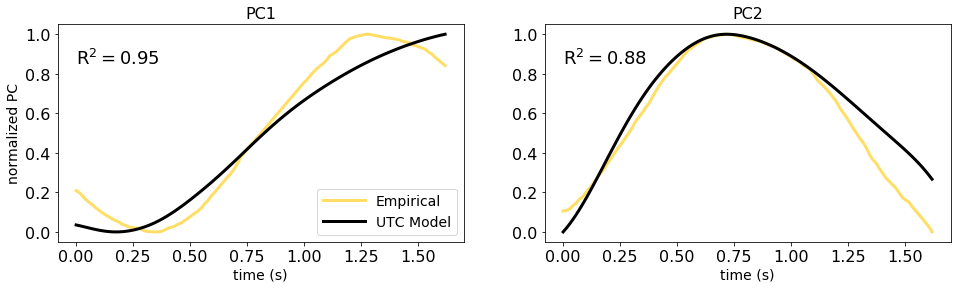

In [528]:
from sklearn.metrics import r2_score

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
t = np.linspace(0, 1620, num=113)/1000

# PC1
step = int(gouvea_pca_long.shape[0] / gouvea_pca_empirical.shape[0])
pca = gouvea_pca_long[0:1620-3*step:step, 0]

# min-max normalization
pca_min = np.min(pca)
pca_max = np.max(pca)
norm_pca_model = (pca - pca_min) / (pca_max - pca_min) 

pca = -gouvea_pca_empirical[:, 0]
pca_min = np.min(pca)
pca_max = np.max(pca)
norm_pca_empirical = (pca - pca_min) / (pca_max - pca_min) 

ax1.plot(t, norm_pca_empirical, 
         color='#ffde66', lw=3, label='Empirical')
ax1.plot(t, norm_pca_model,
         color='black', lw=3, label='UTC Model')

ax1.set_xlabel('time (s)')
ax1.set_ylabel('normalized PC')
ax1.set_title('PC1')
ax1.legend(loc='lower right')

r2_pc1 = r2_score(norm_pca_empirical, norm_pca_model)
ax1.text(0, 0.85, r'$R^2 = {}$'.format(round(r2_pc1, 2)), size=18)

# PC2
step = int(gouvea_pca_long.shape[0] / gouvea_pca_empirical.shape[0])
pca = -gouvea_pca_long[0:1620-3*step:step, 1]

# min-max normalization
pca_min = np.min(pca)
pca_max = np.max(pca)
norm_pca_model = (pca - pca_min) / (pca_max - pca_min) 

pca = gouvea_pca_empirical[:, 1]
pca_min = np.min(pca)
pca_max = np.max(pca)
norm_pca_empirical = (pca - pca_min) / (pca_max - pca_min)

ax2.plot(t, norm_pca_empirical,
        color='#ffde66', lw=3, label='Empirical')
ax2.plot(t, norm_pca_model,
        color='black', lw=3, label='UTC Model')

ax2.set_xlabel('time (s)')
ax2.set_title('PC2')
r2_pc2 = r2_score(norm_pca_empirical, norm_pca_model)

ax2.text(0, 0.85, r'$R^2 = {:.2f}$'.format(round(r2_pc2, 2)), size=18)

#fig.savefig('Gouvea_pca_fit.png', dpi=600, bbox_inches='tight')

(-0.10500000000000001, 1.105, -0.10500000000000001, 1.105)

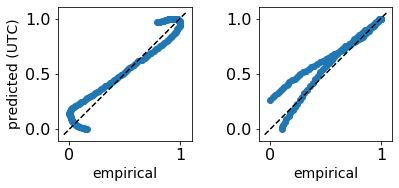

In [572]:
fig, (ax1, ax2) = plt.subplots(1, 2)
plt.subplots_adjust(wspace=0.5)

ax1.scatter(np.concatenate([pca1_empirical]),
           np.concatenate([pca1_model]))
ax1.set_xlim([-0.05, 1.05])
ax1.set_ylim([-0.05, 1.05])
ax1.plot([-0.05, 1.05], [-0.05, 1.05], color='black', ls='--')

ax1.set_xlabel('empirical')
ax1.set_ylabel('predicted (UTC)')
ax1.axis('square')

ax2.scatter(np.concatenate([pca2_empirical]),
           np.concatenate([pca2_model]))
ax2.set_xlim([-0.05, 1.05])
ax2.set_ylim([-0.05, 1.05])
ax2.plot([-0.05, 1.05], [-0.05, 1.05], color='black', ls='--')

ax2.set_xlabel('empirical')

ax2.axis('square')

In [529]:
# Checking how well perfect ramping input would fit
pca = gouvea_pca_empirical[:, 0]
pca_min = np.min(pca)
pca_max = np.max(pca)
norm_pca_empirical = (pca - pca_min) / (pca_max - pca_min) 

r2_score(norm_pca_empirical, np.linspace(1, 0, 113))

0.8397803681349609

In [530]:
# Checking how well the square of a ramping input would fit
pca = gouvea_pca_empirical[:, 1]
pca_min = np.min(pca)
pca_max = np.max(pca)
norm_pca_empirical = (pca - pca_min) / (pca_max - pca_min) 

r2_score(norm_pca_empirical, -np.linspace(-1, 1, 113)**2 + 1)

0.9348519365089004

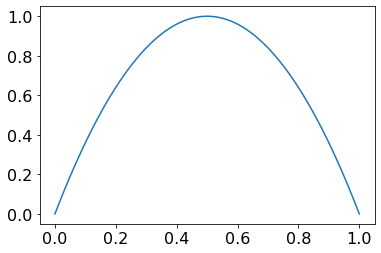

In [531]:
plt.plot(np.linspace(1, 0, 113),
         -np.linspace(-1, 1, 113)**2 + 1)